# Capstone Project - The Battle of Neighborhoods
### Arts and Entertainments in New York City

### Introduction
New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion and sports. Home to the headquarters of the United Nations.
Many districts and landmarks in New York City are well known, including three of the world’s ten most visited tourist attractions in 2013. A record 62.8 million tourists visited New York City in 2017. What entertainments or arts could a tourist have to have a time to chill after he/she visits the famous landmarks in his/her spare time in New York City?

### Data
To answer the question above, the following data should be collected:
1.	New York City data that contains borough, neighborhoods along with their coordinates. Provided by the Coursera Lab Exercise. https://cocl.us/new_york_dataset
2.	Population data of New York City, scraping from Wikipedia https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City
3.	Entertainments information in New York City, fetching from Foursquare API

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import folium

### Methodology

In [2]:
def get_new_york_data():
    """
    This method is to collect New York City data with Borough, Neighborhood, Latitude and Longitude. 
    Will return a pandas dataframe
    """
    NY_DATASET = "https://cocl.us/new_york_dataset"
    resp = requests.get(NY_DATASET).json()

    features = resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    new_york_data = pd.DataFrame(columns=column_names)

    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

    return new_york_data

In [3]:
nyc_df = get_new_york_data()
nyc_df.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [4]:
def get_population_per_neighbourhood(read_from_csv=True):
    """
    It will first fetch the borugh and neighborhood table from wikipedia. 
    Then go to each link of the neighborhoods in the table. 
    Finally, it will create a dataframe cotaining Borough, Neighborhood and Population. 
    It has a functionality to store the data in csv format, 
    and it is possible to read this data from csv to reduce time consuming operations later.
    """
    if not read_from_csv:
        WIKI_LINK = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
        ROOT_WIKI_LINK = "https://en.wikipedia.org"
        page = requests.get(WIKI_LINK)
        soup = BeautifulSoup(page.text, 'html.parser')
        population_list = []
        for table_row in soup.select("table.wikitable tr"):
            cells = table_row.findAll('td')
            if len(cells) > 0:
                borough = cells[0].text.strip().replace(
                    '\xa0', ' ').split(' ')[0]
                population = int(cells[3].text.strip().replace(',', ''))
                for item in cells[4].findAll('a'):
                    neighborhood = item.text
                    neighbourhood_page = requests.get(
                        ROOT_WIKI_LINK+item['href'])
                    soup = BeautifulSoup(
                        neighbourhood_page.text, 'html.parser')
                    table = soup.select("table.infobox tr")
                    should_record = False
                    for row in table:
                        head = row.find('th')
                        body = row.find('td')
                        if head and 'population' in head.text.lower():
                            should_record = True
                            continue
                        if should_record:
                            try:
                                population_list.append(
                                    [borough, neighborhood, int(body.text.replace(',', ''))])
                            except:
                                pass
                            should_record = False
        df = pd.DataFrame(population_list, columns=[
                          "Borough", "Neighborhood", "Population"])
        df.to_csv('population.csv')
    else:
        df = pd.read_csv(r'C:\Users\gey13\Desktop\Coursera\Python for DS\Applied Data Science Capstone\population.csv',index_col=[0])
    df = df.sort_values(by=['Borough'])
    df = df.drop_duplicates(subset='Neighborhood', keep='last')
    return df

In [5]:
nyc_population_df = get_population_per_neighbourhood()
nyc_population_df.head()

Borough  Neighborhood  Population
0    Bronx       Melrose       24913
25   Bronx      Bruckner       38557
26   Bronx   Castle Hill       38557
27   Bronx  Clason Point        9136
28   Bronx  Harding Park        9136

In [6]:
# Merge NYC Geo data with population data
nyc_df.set_index('Neighborhood')
nyc_population_df.set_index('Neighborhood')
nyc_full_df = pd.merge(nyc_df,nyc_population_df,how='inner',on=['Borough','Neighborhood'])
nyc_full_df.head()

Borough Neighborhood   Latitude  Longitude  Population
0   Bronx    Wakefield  40.894705 -73.847201       29158
1   Bronx   Co-op City  40.874294 -73.829939       43752
2   Bronx    Fieldston  40.895437 -73.905643        3292
3   Bronx    Riverdale  40.890834 -73.912585       48049
4   Bronx  Kingsbridge  40.881687 -73.902818       10669

In [7]:
# Let us see some bar charts of this data
def show_bar_chart(df, group, field, title, x_label, y_label, calculation="sum"):
    """
    A generic function to render bar charts
    """
    plt.figure(figsize=(9, 5), dpi=100)
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    if calculation == "sum":
        df.groupby(group)[field].sum().plot(kind='bar')
    if calculation == "count":
        df.groupby(group)[field].count().plot(kind='bar')
    plt.legend()
    plt.show()

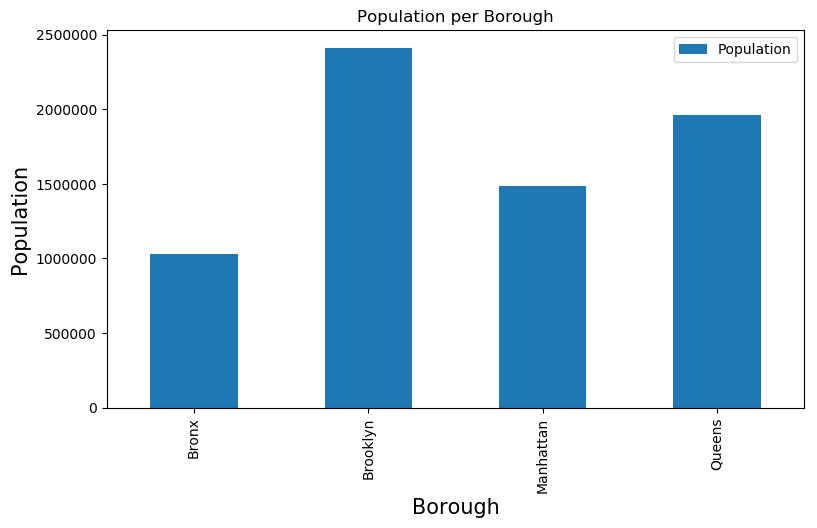

In [8]:
show_bar_chart(nyc_full_df, 
               group="Borough", 
               field="Population", 
               title="Population per Borough",  
               x_label="Borough", 
               y_label="Population")

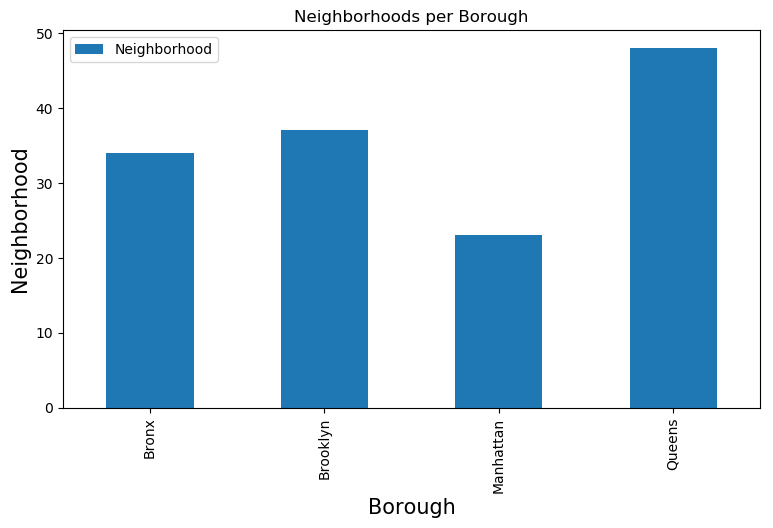

In [9]:
show_bar_chart(nyc_full_df,
               group="Borough",
               field="Neighborhood",
               title="Neighborhoods per Borough",
               x_label="Borough",
               y_label="Neighborhood",
               calculation="count")

In [10]:
# fetch entertainment information for each Neighborhood
def get_entertainment_data(lat, lng, borough, neighborhood):
    """
    We are going to utilize foursquare API to fetch restaurant data. 
    It will take latitude, longitude and return restaurant information.
    """
    radius = 1000
    LIMIT = 100
    VERSION = '20200328'
    FS_CLIENT_ID = "D54R2BDBTX2UFMJW00LFANFIL02YNZNX1RQ02OKTIODFMYWM"
    FS_CLIENT_SECRET = "ZK4VCF3E210JHQFX4BDIX5QJ0JGFIZV1WK3VMUO0ESVNDDIU"
    FS_ENTERTAINMENT_KEY = "4d4b7104d754a06370d81259"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_ENTERTAINMENT_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            cat = row['categories'][0]['name']
            venue_details.append(
                [venue_id, venue_name, cat, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['ID', 'Name', 'Category', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [11]:
# function to utilize the nyc_full_df to get entertainment data
def get_entertainment_per_neighborhood_borough(df):
    """
    It will utilize nyc_full_df and get entertainment per neighborhood.
    """
    column_names = ['ID', 'Name', 'Category', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        h_df = get_entertainment_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
    n_df.to_csv('entertainment_per_boro_nei.csv')
    return n_df

In [12]:
# Search arts and entertainments
entertainment_df = get_entertainment_per_neighborhood_borough(nyc_full_df)
entertainment_df.head()

ID                          Name     Category  \
0  4f57ef61e4b063a4ab675858                The Upper Room  Music Venue   
1  4d23aea014f2b1f7740f68be                      Par-City  Music Venue   
2  4f32c48519836c91c7f85d13       Ultimate Gaming Centers       Arcade   
3  4f32bd8019836c91c7f54f3e  Art Gallery Illusion Reality  Art Gallery   
4  4efb879502d5a2b50e03c616                 Matic Records  Music Venue   

    Latitude  Longitude Borough Neighborhood  
0  40.892567 -73.846406   Bronx    Wakefield  
1  40.890211 -73.847002   Bronx    Wakefield  
2  40.891754 -73.857947   Bronx    Wakefield  
3  40.894949 -73.856470   Bronx    Wakefield  
4  40.899774 -73.857141   Bronx    Wakefield

In [13]:
# Merge nyc_full_df and entertainment_df
nyc_entertainment_df = pd.merge(nyc_full_df,
                             entertainment_df[['Borough','Neighborhood','ID','Name','Category']], 
                             how='inner',
                             on=['Borough','Neighborhood'])
nyc_entertainment_df.head()

Borough Neighborhood   Latitude  Longitude  Population  \
0   Bronx    Wakefield  40.894705 -73.847201       29158   
1   Bronx    Wakefield  40.894705 -73.847201       29158   
2   Bronx    Wakefield  40.894705 -73.847201       29158   
3   Bronx    Wakefield  40.894705 -73.847201       29158   
4   Bronx    Wakefield  40.894705 -73.847201       29158   

                         ID                          Name     Category  
0  4f57ef61e4b063a4ab675858                The Upper Room  Music Venue  
1  4d23aea014f2b1f7740f68be                      Par-City  Music Venue  
2  4f32c48519836c91c7f85d13       Ultimate Gaming Centers       Arcade  
3  4f32bd8019836c91c7f54f3e  Art Gallery Illusion Reality  Art Gallery  
4  4efb879502d5a2b50e03c616                 Matic Records  Music Venue

In [14]:
print('There are {} unique categories.'.format(len(nyc_entertainment_df['Category'].unique())))

There are 160 unique categories.


In [15]:
# one hot encoding
nyc_entertainment_onehot = pd.get_dummies(nyc_entertainment_df[['Category']],prefix='',prefix_sep='')

# add neighborhood column back to dataframe
nyc_entertainment_onehot['Neighborhood'] = nyc_entertainment_df['Neighborhood']

# move neighborhood column to the first column
fix_columns = [nyc_entertainment_onehot.columns[-1]] + list(nyc_entertainment_onehot.columns[:-1])
nyc_entertainment_onehot = nyc_entertainment_onehot[fix_columns]
nyc_entertainment_onehot.head()

Neighborhood  American Restaurant  Amphitheater  Antique Shop  Aquarium  \
0    Wakefield                    0             0             0         0   
1    Wakefield                    0             0             0         0   
2    Wakefield                    0             0             0         0   
3    Wakefield                    0             0             0         0   
4    Wakefield                    0             0             0         0   

   Arcade  Art Gallery  Art Museum  Art Studio  Arts & Crafts Store  ...  \
0       0            0           0           0                    0  ...   
1       0            0           0           0                    0  ...   
2       1            0           0           0                    0  ...   
3       0            1           0           0                    0  ...   
4       0            0           0           0                    0  ...   

   Tourist Information Center  Trail  University  Video Game Store  \
0                           0      0           0                 0   
1                           0      0           0                 0   
2                           0      0           0                 0   
3                           0      0           0                 0   
4                           0      0           0                 0   

   Video Store  Warehouse  Wine Bar  Yoga Studio  Zoo  Zoo Exhibit  
0            0          0         0            0    0            0  
1            0          0         0            0    0            0  
2            0          0         0            0    0            0  
3            0          0         0            0    0            0  
4            0          0         0            0    0            0  

[5 rows x 161 columns]

In [16]:
nyc_entertainment_onehot.shape

(4034, 161)

In [17]:
# group row by neighborhood and by taking the mean of the frequency of occurrence of each category
nyc_entertainment_grp = nyc_entertainment_onehot.groupby('Neighborhood').mean().reset_index()
nyc_entertainment_grp.head()

Neighborhood  American Restaurant  Amphitheater  Antique Shop  \
0            Arverne                  0.0           0.0           0.0   
1         Bath Beach                  0.0           0.0           0.0   
2  Battery Park City                  0.0           0.0           0.0   
3          Bay Ridge                  0.0           0.0           0.0   
4        Bay Terrace                  0.0           0.0           0.0   

   Aquarium    Arcade  Art Gallery  Art Museum  Art Studio  \
0       0.0  0.000000     0.333333         0.0         0.0   
1       0.0  0.153846     0.038462         0.0         0.0   
2       0.0  0.000000     0.040816         0.0         0.0   
3       0.0  0.086957     0.239130         0.0         0.0   
4       0.0  0.000000     0.000000         0.0         0.0   

   Arts & Crafts Store  ...  Tourist Information Center  Trail  University  \
0                  0.0  ...                         0.0    0.0         0.0   
1                  0.0  ...                         0.0    0.0         0.0   
2                  0.0  ...                         0.0    0.0         0.0   
3                  0.0  ...                         0.0    0.0         0.0   
4                  0.0  ...                         0.0    0.0         0.0   

   Video Game Store  Video Store  Warehouse  Wine Bar  Yoga Studio  Zoo  \
0               0.0          0.0        0.0       0.0     0.000000  0.0   
1               0.0          0.0        0.0       0.0     0.038462  0.0   
2               0.0          0.0        0.0       0.0     0.000000  0.0   
3               0.0          0.0        0.0       0.0     0.000000  0.0   
4               0.0          0.0        0.0       0.0     0.000000  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 161 columns]

In [18]:
nyc_entertainment_grp.shape

(141, 161)

In [19]:
# find top most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_entertainment_grp['Neighborhood']

for ind in np.arange(nyc_entertainment_grp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_entertainment_grp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  1st Most Common Venue  2nd Most Common Venue  \
0            Arverne             Public Art            Art Gallery   
1         Bath Beach  General Entertainment                 Arcade   
2  Battery Park City  General Entertainment          Historic Site   
3          Bay Ridge            Art Gallery  General Entertainment   
4        Bay Terrace  General Entertainment           Dance Studio   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Historic Site           Zoo Exhibit              Fountain   
1          Dance Studio             Multiplex  Arts & Entertainment   
2         Memorial Site   Monument / Landmark     Outdoor Sculpture   
3          Dance Studio                Arcade  Arts & Entertainment   
4      Football Stadium           Comedy Club         Movie Theater   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  General College & University               Gay Bar             Gastropub   
1                Gymnastics Gym           Comedy Club         Movie Theater   
2                   Art Gallery              Building           Music Venue   
3                   Music Venue         Historic Site         Movie Theater   
4                 Indie Theater        History Museum               Theater   

    9th Most Common Venue 10th Most Common Venue  
0  Furniture / Home Store      French Restaurant  
1             Pizza Place             Theme Park  
2            Dance Studio    Government Building  
3               Multiplex              Rock Club  
4           Historic Site                Gay Bar

In [21]:
# Now we are going to use k-means clustering to partition data in k partitions
# We are going to use elbow method to find the optimum number of cluster

def plot_kmeans(dataset):
    obs = dataset.copy()
    silhouette_score_values = list()
    number_of_clusters = range(3, 30)
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

    plt.plot(number_of_clusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()

    optimum_number_of_components = number_of_clusters[silhouette_score_values.index(
        max(silhouette_score_values))]
    print("Optimal number of components is:")
    print(optimum_number_of_components)

In [22]:
# clustering
nyc_entertainment_clusters = nyc_entertainment_grp.drop('Neighborhood',1)
nyc_entertainment_clusters_clusters = sklearn.preprocessing.StandardScaler().fit_transform(nyc_entertainment_clusters)

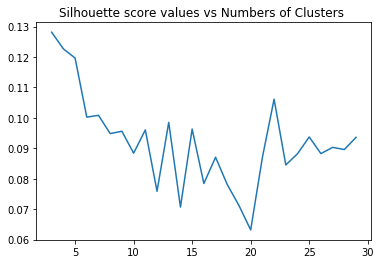

Optimal number of components is:
3


In [23]:
# Performing k-means clustering
plot_kmeans(nyc_entertainment_clusters)

In [24]:
# set number of clusters = 3
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_entertainment_clusters)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15] 

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1])

In [25]:
# adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

Cluster Labels       Neighborhood  1st Most Common Venue  \
0               0            Arverne             Public Art   
1               0         Bath Beach  General Entertainment   
2               0  Battery Park City  General Entertainment   
3               0          Bay Ridge            Art Gallery   
4               1        Bay Terrace  General Entertainment   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0            Art Gallery         Historic Site           Zoo Exhibit   
1                 Arcade          Dance Studio             Multiplex   
2          Historic Site         Memorial Site   Monument / Landmark   
3  General Entertainment          Dance Studio                Arcade   
4           Dance Studio      Football Stadium           Comedy Club   

  5th Most Common Venue         6th Most Common Venue 7th Most Common Venue  \
0              Fountain  General College & University               Gay Bar   
1  Arts & Entertainment                Gymnastics Gym           Comedy Club   
2     Outdoor Sculpture                   Art Gallery              Building   
3  Arts & Entertainment                   Music Venue         Historic Site   
4         Movie Theater                 Indie Theater        History Museum   

  8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  
0             Gastropub  Furniture / Home Store      French Restaurant  
1         Movie Theater             Pizza Place             Theme Park  
2           Music Venue            Dance Studio    Government Building  
3         Movie Theater               Multiplex              Rock Club  
4               Theater           Historic Site                Gay Bar

In [26]:
def get_geo_location(address):
    """
    This function will return lattitude and longitude of an given address
    """
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        return [latitude, longitude]
    return [None, None]

In [27]:
coordinates = get_geo_location('New York')
latitude = coordinates[0]
longitude = coordinates[1]

In [28]:
nyc_entertainment_merged = nyc_entertainment_df
nyc_entertainment_merged = nyc_entertainment_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),on='Neighborhood')
nyc_entertainment_merged.head()

Borough Neighborhood   Latitude  Longitude  Population  \
0   Bronx    Wakefield  40.894705 -73.847201       29158   
1   Bronx    Wakefield  40.894705 -73.847201       29158   
2   Bronx    Wakefield  40.894705 -73.847201       29158   
3   Bronx    Wakefield  40.894705 -73.847201       29158   
4   Bronx    Wakefield  40.894705 -73.847201       29158   

                         ID                          Name     Category  \
0  4f57ef61e4b063a4ab675858                The Upper Room  Music Venue   
1  4d23aea014f2b1f7740f68be                      Par-City  Music Venue   
2  4f32c48519836c91c7f85d13       Ultimate Gaming Centers       Arcade   
3  4f32bd8019836c91c7f54f3e  Art Gallery Illusion Reality  Art Gallery   
4  4efb879502d5a2b50e03c616                 Matic Records  Music Venue   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               2           Music Venue                Arcade   
1               2           Music Venue                Arcade   
2               2           Music Venue                Arcade   
3               2           Music Venue                Arcade   
4               2           Music Venue                Arcade   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0  General Entertainment           Art Gallery  Performing Arts Venue   
1  General Entertainment           Art Gallery  Performing Arts Venue   
2  General Entertainment           Art Gallery  Performing Arts Venue   
3  General Entertainment           Art Gallery  Performing Arts Venue   
4  General Entertainment           Art Gallery  Performing Arts Venue   

  6th Most Common Venue 7th Most Common Venue         8th Most Common Venue  \
0           Zoo Exhibit      Fraternity House  General College & University   
1           Zoo Exhibit      Fraternity House  General College & University   
2           Zoo Exhibit      Fraternity House  General College & University   
3           Zoo Exhibit      Fraternity House  General College & University   
4           Zoo Exhibit      Fraternity House  General College & University   

  9th Most Common Venue 10th Most Common Venue  
0               Gay Bar              Gastropub  
1               Gay Bar              Gastropub  
2               Gay Bar              Gastropub  
3               Gay Bar              Gastropub  
4               Gay Bar              Gastropub

### Results

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_entertainment_merged['Latitude'], nyc_entertainment_merged['Longitude'], nyc_entertainment_merged['Neighborhood'], nyc_entertainment_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
# examine clusters
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==0]

Borough  Neighborhood   Latitude  Longitude  Population  \
12        Bronx    Co-op City  40.874294 -73.829939       43752   
13        Bronx    Co-op City  40.874294 -73.829939       43752   
14        Bronx    Co-op City  40.874294 -73.829939       43752   
15        Bronx    Co-op City  40.874294 -73.829939       43752   
16        Bronx    Co-op City  40.874294 -73.829939       43752   
17        Bronx    Co-op City  40.874294 -73.829939       43752   
18        Bronx    Co-op City  40.874294 -73.829939       43752   
19        Bronx    Co-op City  40.874294 -73.829939       43752   
20        Bronx    Co-op City  40.874294 -73.829939       43752   
21        Bronx    Co-op City  40.874294 -73.829939       43752   
22        Bronx    Co-op City  40.874294 -73.829939       43752   
23        Bronx    Co-op City  40.874294 -73.829939       43752   
24        Bronx    Co-op City  40.874294 -73.829939       43752   
98        Bronx      Woodlawn  40.898273 -73.867315       42483   
99        Bronx      Woodlawn  40.898273 -73.867315       42483   
100       Bronx      Woodlawn  40.898273 -73.867315       42483   
101       Bronx      Woodlawn  40.898273 -73.867315       42483   
102       Bronx      Woodlawn  40.898273 -73.867315       42483   
103       Bronx      Woodlawn  40.898273 -73.867315       42483   
104       Bronx      Woodlawn  40.898273 -73.867315       42483   
105       Bronx      Woodlawn  40.898273 -73.867315       42483   
106       Bronx      Woodlawn  40.898273 -73.867315       42483   
107       Bronx      Woodlawn  40.898273 -73.867315       42483   
108       Bronx      Woodlawn  40.898273 -73.867315       42483   
109       Bronx      Woodlawn  40.898273 -73.867315       42483   
110       Bronx      Woodlawn  40.898273 -73.867315       42483   
111       Bronx      Woodlawn  40.898273 -73.867315       42483   
112       Bronx      Woodlawn  40.898273 -73.867315       42483   
113       Bronx       Norwood  40.877224 -73.879391       40494   
114       Bronx       Norwood  40.877224 -73.879391       40494   
...         ...           ...        ...        ...         ...   
4004  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4005  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4006  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4007  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4008  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4009  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4010  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4011  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4012  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4013  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4014  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4015  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4016  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4017  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4018  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4019  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4020  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4021  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4022  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4023  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4024  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4025  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4026  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4027  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4028  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4029  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4030  Manhattan  Hudson Yards  40.756658 -74.000111       70150   
4031  Manhattan  Hudson Yards  40.756658 -74.000111    

In [39]:
# count number of entertainments in each Borough in first cluster
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==0].groupby('Borough')['ID'].nunique()

Borough
Bronx        316
Brooklyn     831
Manhattan    709
Queens       473
Name: ID, dtype: int64

In [31]:
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==1]

Borough    Neighborhood   Latitude  Longitude  Population  \
172      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
173      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
174      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
175      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
176      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
177      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
178      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
179      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
180      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
181      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
182      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
183      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
184      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
185      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
186      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
187      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
188      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
189      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
190      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
191      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
192      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
193      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
194      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
195      Bronx  Pelham Parkway  40.857413 -73.854756       30073   
552      Bronx       Soundview  40.821012 -73.865746       31825   
553      Bronx       Soundview  40.821012 -73.865746       31825   
554      Bronx       Soundview  40.821012 -73.865746       31825   
555      Bronx       Soundview  40.821012 -73.865746       31825   
556      Bronx       Soundview  40.821012 -73.865746       31825   
557      Bronx       Soundview  40.821012 -73.865746       31825   
...        ...             ...        ...        ...         ...   
3915  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3916  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3917  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3918  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3919  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3920  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3921  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3922  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3923  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3924  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3925  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3926  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3927  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3928  Brooklyn       Homecrest  40.598525 -73.959185       44316   
3929    Queens  Middle Village  40.716415 -73.881143       37929   
3930    Queens  Middle Village  40.716415 -73.881143       37929   
3931    Queens  Middle Village  40.716415 -73.881143       37929   
3932    Queens  Middle Village  40.716415 -73.881143       37929   
3933    Queens  Middle Village  40.716415 -73.881143       37929   
3934    Queens  Middle Village  40.716415 -73.881143       37929   
3935    Queens  Middle Village  40.716415 -73.881143       37929   
3936    Queens  Middle Village  40.716415 -73.881143       37929   
3937    Queens  Middle Village  40.716415 -73.881143       37929   
3938    Queens  Middle Village  40.716415 -73.881143       37929   
3939    Queens  Middle Village  40.716415 -73.881143       37929   
3940    Queens  Middle Village  40.716415 -73.881143       37929   
3941    Queens  Middle Village  40.716415 -73.881143       3792

In [40]:
# count number of entertainments in each Borough in second cluster
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==1].groupby('Borough')['ID'].nunique()

Borough
Bronx        106
Brooklyn      65
Manhattan     43
Queens       200
Name: ID, dtype: int64

In [32]:
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==2]

Borough Neighborhood   Latitude  Longitude  Population  \
0        Bronx    Wakefield  40.894705 -73.847201       29158   
1        Bronx    Wakefield  40.894705 -73.847201       29158   
2        Bronx    Wakefield  40.894705 -73.847201       29158   
3        Bronx    Wakefield  40.894705 -73.847201       29158   
4        Bronx    Wakefield  40.894705 -73.847201       29158   
5        Bronx    Wakefield  40.894705 -73.847201       29158   
6        Bronx    Wakefield  40.894705 -73.847201       29158   
7        Bronx    Wakefield  40.894705 -73.847201       29158   
8        Bronx    Wakefield  40.894705 -73.847201       29158   
9        Bronx    Wakefield  40.894705 -73.847201       29158   
10       Bronx    Wakefield  40.894705 -73.847201       29158   
11       Bronx    Wakefield  40.894705 -73.847201       29158   
25       Bronx    Fieldston  40.895437 -73.905643        3292   
26       Bronx    Fieldston  40.895437 -73.905643        3292   
27       Bronx    Fieldston  40.895437 -73.905643        3292   
28       Bronx    Fieldston  40.895437 -73.905643        3292   
29       Bronx    Fieldston  40.895437 -73.905643        3292   
30       Bronx    Fieldston  40.895437 -73.905643        3292   
31       Bronx    Fieldston  40.895437 -73.905643        3292   
32       Bronx    Fieldston  40.895437 -73.905643        3292   
33       Bronx    Fieldston  40.895437 -73.905643        3292   
34       Bronx    Fieldston  40.895437 -73.905643        3292   
35       Bronx    Fieldston  40.895437 -73.905643        3292   
36       Bronx    Fieldston  40.895437 -73.905643        3292   
37       Bronx    Fieldston  40.895437 -73.905643        3292   
38       Bronx    Fieldston  40.895437 -73.905643        3292   
39       Bronx    Fieldston  40.895437 -73.905643        3292   
40       Bronx    Fieldston  40.895437 -73.905643        3292   
41       Bronx    Fieldston  40.895437 -73.905643        3292   
42       Bronx    Fieldston  40.895437 -73.905643        3292   
...        ...          ...        ...        ...         ...   
3954  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3955  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3956  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3957  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3958  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3959  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3960  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3961  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3962  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3963  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3964  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3965  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3966  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3967  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3968  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3969  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3970  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3971  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3972  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3973  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3974  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3975  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3976  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3977  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3978  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3979  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3980  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3981  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3982  Brooklyn      Erasmus  40.646926 -73.948177      135619   
3983  Brooklyn      Erasmus  40.646926 -73

In [41]:
# count number of entertainments in each Borough in third cluster
nyc_entertainment_merged.loc[nyc_entertainment_merged['Cluster Labels']==2].groupby('Borough')['ID'].nunique()

Borough
Bronx       109
Brooklyn     88
Queens       91
Name: ID, dtype: int64

### Conclusions
From the bar plot in the methodology section, it can be seen that Brooklyn has the largest population and followed by Queens. While Queens has the most number neighborhoods.
<br>
In the first cluster, Brooklyn has the largest number of the Arts/Entertainment venue (831) which are located in Brooklyn and the 1st common venue is Art Gallery.
<br>
while in the second cluster, there are 200 Art/Entertainment venues in Queens and the General Entertainment becomes the most common venue in this cluster.
Lastly, Bronx has the 109 Art/Entertainment venues and Music Venue is the most popular place here.
<br>
Therefore, Brooklyn may be the right choice to chill during after your full schedualed journey. There are more spots including arts, general entertainment and music venues. You may also have higher chance to make friends during these time as Brooklyn has the largest population in New York City.